In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import rc
import warnings
from typing import List, Tuple
import sys

sys.path.append('../')
from common_util import NogamiConductivityData,setup_axis_default,get_k_most_commmon_feature_transform,hdi, ProjectPaths,setup_plotting_format

#ignore warnings and set preference for matplotlib styles
warnings.filterwarnings("ignore")
setup_plotting_format()
paths = ProjectPaths()

#load data
nogami_data = NogamiConductivityData()  


### Feature Selection 

This model has the same goals and approach as discussed in the [uts_modeling.ipynb](uts_modeling.ipynb) notebook, so take a look at that first to understand the methodology.  I'll note here that that the fourth order polynomial basis is included because insepection of the residuals suggested this could improve the model fit. It's interesting that only polynomial features are chosen by the feature selection here, though this is likely in part due to not scaling the data. I've chosen not to scale the data during fitting for reasons I'll discuss later in this notebook.

In [3]:
from common_util import TransformedFeature,identity,inverted,power,constant, power_derivative
from functools import partial   

features = [TransformedFeature('x',identity,derivative= partial(constant,1)),
            TransformedFeature('log x',np.log,derivative = inverted),
            TransformedFeature('x^0.5',np.sqrt,derivative= power_derivative(0.5)),
            TransformedFeature('x^2',partial(power,2),derivative = power_derivative(2)),
            TransformedFeature('x^3',partial(power,3), derivative = power_derivative(3)),
            TransformedFeature('x^4',partial(power,4), derivative = power_derivative(4))] 


data= [nogami_data[key] for key in nogami_data.keys()]

feature_transform = get_k_most_commmon_feature_transform(data,6,input_features= features[:],scale = False)

print(f'selected features: {str(feature_transform)}')

data_transform = feature_transform.make_sklearn_transform(scale = False)

yprime = data_transform.deriv(np.array([[1200.,1500.]]).T)

selected features: ['1', 'x^3', 'x^4', 'x^2', 'x']


### Model Visualization

Unlike uniform elongation, and to some extent ultimate tensile stress, the curves are relatively well behaved. The fitted curves look pretty good.

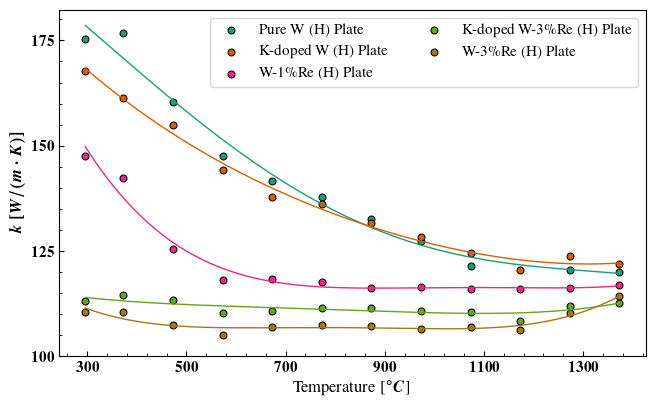

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

fig,ax = plt.subplots(figsize = (6.5,4),ncols = 1)
setup_axis_default(ax)
for i,column in enumerate(nogami_data.keys()):
    color = i/len(nogami_data.keys())
    x,y = nogami_data[column]

    xp = np.linspace(x.min(),x.max(),1000)[:,np.newaxis]

    pipe = Pipeline([('transform',data_transform),
                     ('model',LinearRegression(fit_intercept= False))])

    pipe.fit(x,y)
    y_pred = pipe.predict(xp)
    ax.plot(xp,y_pred,lw = 1.,zorder = 100,
            color = plt.get_cmap('Dark2')(color))

    ax.scatter(x,y,s = 25,edgecolor = 'k',
            lw = 0.75,facecolor = plt.get_cmap('Dark2')(color),
            label = column.replace('%','\%'))

ax.legend(fontsize = 11,ncols = 2)



ax.set_xlabel('Temperature [$^\circ C$]',fontsize = 12)
ax.set_xticks(np.arange(300,1400,200))
ax.set_yticks(np.arange(100,200,25))
ax.set_ylabel('$k \ [W/(m \cdot K)]$',fontsize = 12)
fig.tight_layout(pad = 0.5) 

### Residual Analysis

There still appear to be some influential points/erroneous measurements that may be distorting the shape of the model . Examining The residuals via Q-Q plots and Residuals vs. Predicted values can help us identify these points. Also shown are the usual Cooks distance and DFFITS plots.

Pure W (H) Plate possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------


K-doped W (H) Plate possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------


W-1%Re (H) Plate possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------


K-doped W-3%Re (H) Plate possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------


W-3%Re (H) Plate possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------




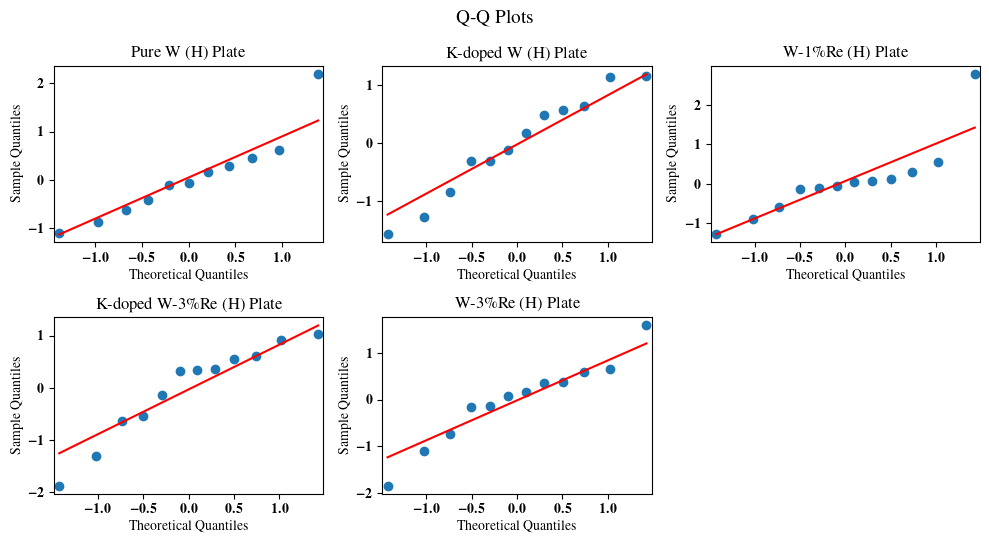

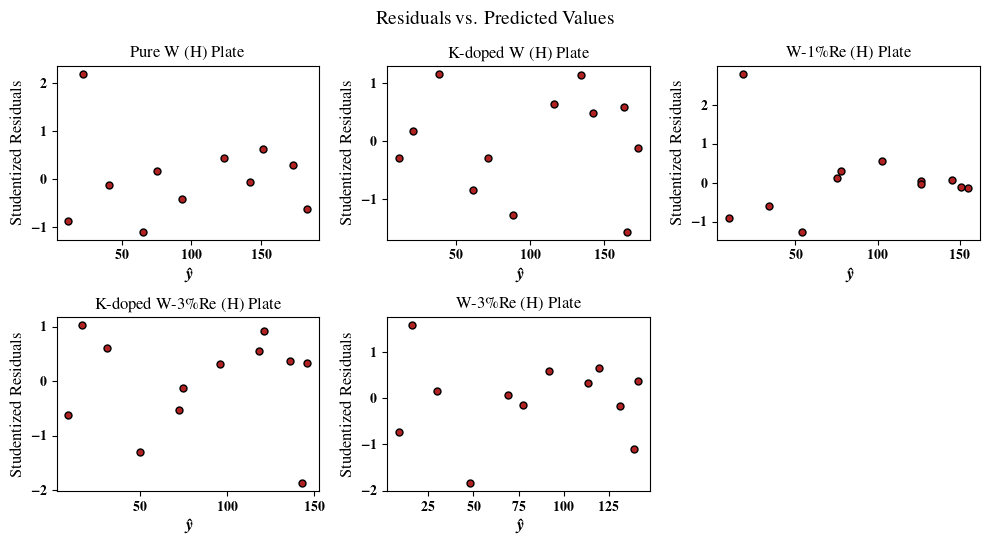

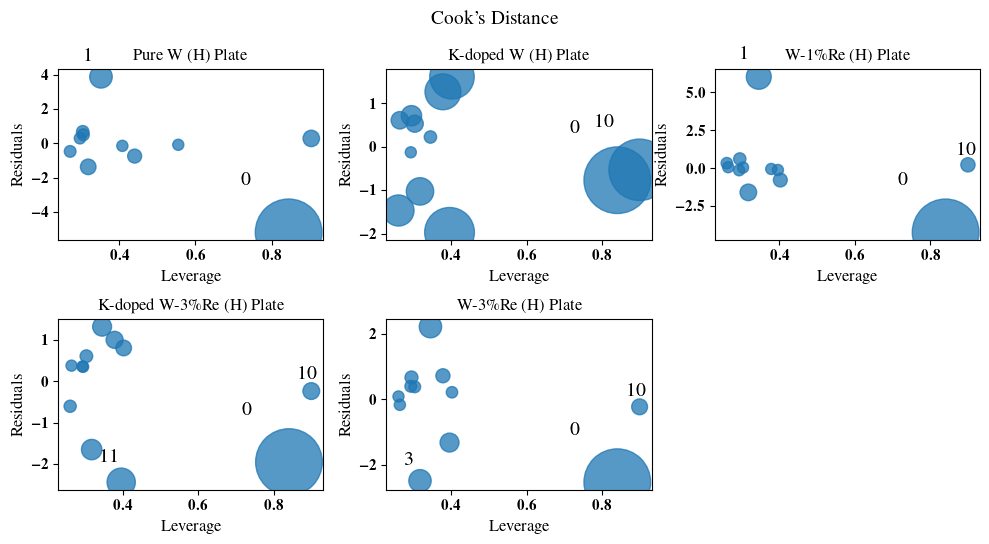

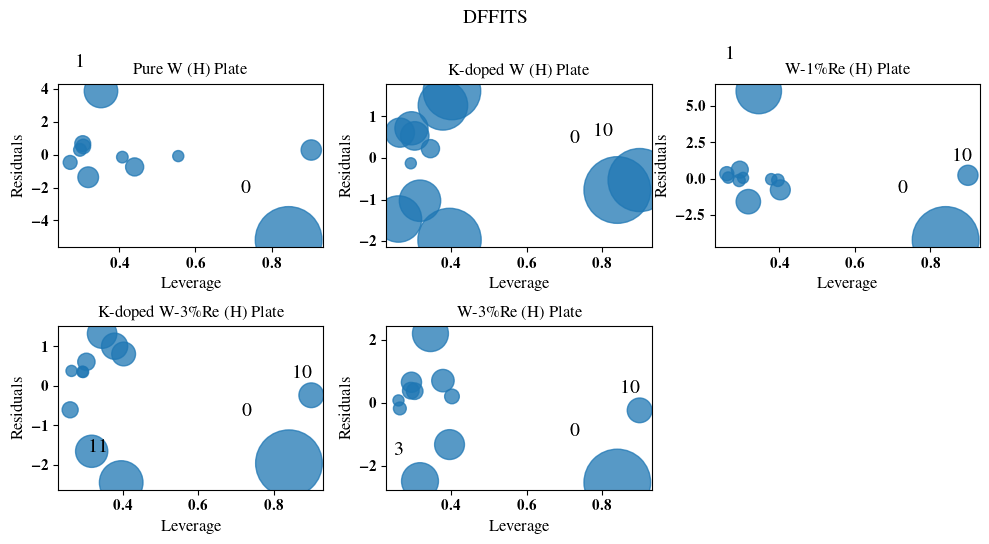

In [5]:
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.regressionplots import influence_plot
from statsmodels.regression.linear_model import OLS as sm_OLS
import scipy

fig,axes = plt.subplots(figsize = (10,5.5),nrows = 2,ncols = 3)
fig2,axes2 = plt.subplots(figsize = (10,5.5),nrows = 2,ncols = 3)
fig3,axes3 = plt.subplots(figsize = (10,5.5),nrows = 2,ncols = 3)
fig4,axes4 = plt.subplots(figsize = (10,5.5),nrows = 2,ncols = 3)
fig.suptitle('Q-Q Plots',fontsize = 14)
fig2.suptitle('Residuals vs. Predicted Values',fontsize = 14)
fig3.suptitle('Cook\'s Distance',fontsize = 14)
fig4.suptitle('DFFITS',fontsize = 14)

for column,ax,ax2,ax3,ax4 in zip(nogami_data.keys(),axes.ravel(),axes2.ravel(),axes3.ravel(),axes4.ravel()):
    label = column.replace('%','\%')
    for a in [ax,ax2]:
        a.set_title(label)

    x,y = nogami_data[column]
    xp = np.linspace(x.min(),x.max(),1000)[:,np.newaxis]

    #make model-data transform pipeline
    pipe = Pipeline([('transform',data_transform),
                        ('model',LinearRegression(fit_intercept= False))])

    pipe.fit(x,y)
    
    #post-porcessing to get diagnostic information
    resid = y - pipe.predict(x)
    X = pipe.named_steps['transform'].transform(x)

    #somewhat annoying, but we need to refit the model to work with statsmodels
    #diagnostic plots. I don't want to code these up myself, so I'll just do it
    sm_ols_res = sm_OLS(y,X).fit()

    #influence plots - cooks distance
    influence_plot(sm_ols_res,ax = ax3,criterion = 'cooks')

    #influence plots - DFFITS
    influence_plot(sm_ols_res,ax = ax4,criterion = 'dffits')

    #really annoying that I can't seem to modify this with keyword arguments to "influence_plot"
    for a in [ax3,ax4]:
        a.set_xlabel('Leverage',fontsize = 12)
        a.set_ylabel('Residuals',fontsize = 12)
        a.tick_params('both',labelsize = 11)
        a.set_title(label,fontsize = 12)

    #potential outliers
    n,p = X.shape
    H = X @ scipy.linalg.pinvh(X.T @ X) @ X.T         
    S2 = np.sum(resid**2)/(n - p)
    S2_i = (n - p)/(n- p - 1)*S2 - 1/(n-p -1)*resid**2/(1 - np.diag(H))
    studentized_residuals = resid/np.sqrt(S2_i*(1 - np.diag(H)))
    
    #print informatoin about potential misfits of data for each data set
    possible_outliers = np.arange(X.shape[0])[np.abs(studentized_residuals) > 3]
    
    print(f'{column} possible outliers:')
    print(f'\tindex: {possible_outliers}')
    print(f'\tstudentized residuals: {studentized_residuals[possible_outliers]}')

    print('\n--------------------------------------------\n\n')
    
    #plot residuals against predicted values and qqplots
    qqplot(studentized_residuals,ax = ax,line = 's',
           color = 'blue')
    ax2.scatter(H @ y,studentized_residuals,edgecolor = 'k',
                facecolor = 'firebrick',s = 25)
    ax2.set_ylabel('Studentized Residuals',fontsize = 12)
    ax2.set_xlabel('$\hat{y}$',fontsize = 12)


for ax in [axes,axes2,axes3,axes4]:
    ax[-1,-1].axis('off') 

for f in [fig,fig2,fig3,fig4]:
    f.tight_layout()


### Data Cleaning and Re-Fitting the Model

As always, an iterative approach, examining the points that diagnositcs point out might be diagnostic and considering if we should keep them in the model or not is followed. As it is now, the residuals look pretty good, and nothing looks weird with the residuals vs. fitted values plot.

Alloy: Pure W (H) Plate | Data Length: 9
possible leverage points: []
possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------


Alloy: K-doped W (H) Plate | Data Length: 11
possible leverage points: []
possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------


Alloy: W-1%Re (H) Plate | Data Length: 9
possible leverage points: []
possible outliers:
	index: [2]
	studentized residuals: [2.06378849]

--------------------------------------------


Alloy: K-doped W-3%Re (H) Plate | Data Length: 10
possible leverage points: []
possible outliers:
	index: [9]
	studentized residuals: [-2.35720655]

--------------------------------------------


Alloy: W-3%Re (H) Plate | Data Length: 11
possible leverage points: []
possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------




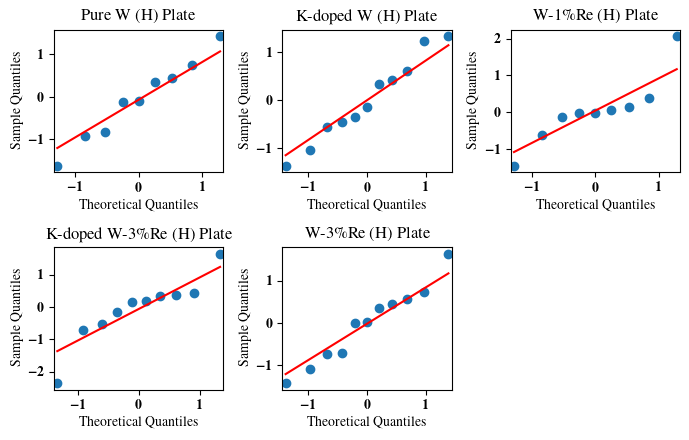

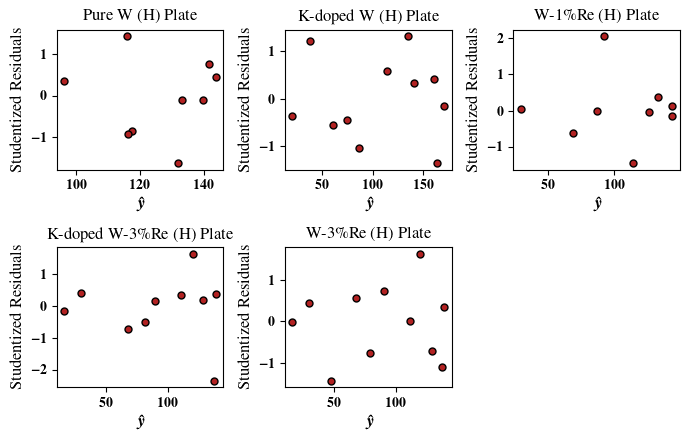

In [6]:
from statsmodels.graphics.gofplots import qqplot
import scipy

def clean_data(x: np.ndarray,y: np.ndarray,remove_points: List[int]):
    mask = np.ones_like(x.squeeze(),dtype = bool)
    mask[remove_points] = False
    return x[mask],y[mask]

fig,axes = plt.subplots(figsize = (7,4.5),nrows = 2,ncols = 3)
fig2,axes2 = plt.subplots(figsize = (7,4.5),nrows = 2,ncols = 3)

remove_data = {'Pure W (H) Plate': [0,1],
               'K-doped W-3%Re (H) Plate':[0,3],
               'W-3%Re (H) Plate':[0],
               'K-doped W (H) Plate': [0],
               'W-1%Re (H) Plate': [0,1,3]}

for column,ax,ax2 in zip(nogami_data.keys(),axes.ravel(),axes2.ravel()):
    label = column.replace('%','\%')
    ax.set_title(label)
    ax2.set_title(label)    

    x,y = nogami_data[column]

    if column in remove_data:
        x,y = clean_data(x,y,remove_data[column])
    

    #make model-data transform pipeline
    pipe = Pipeline([('transform',data_transform),
                        ('model',LinearRegression(fit_intercept= False))])

    pipe.fit(x,y)
    
    #post-porcessing to get diagnostic information
    resid = y - pipe.predict(x)
    X = pipe.named_steps['transform'].transform(x)
    n,p = X.shape
    H = X @ scipy.linalg.pinvh(X.T @ X) @ X.T

    S2 = np.sum(resid**2)/(n - p)
    S2_i = (n - p)/(n- p - 1)*S2 - 1/(n-p -1)*resid**2/(1 - np.diag(H))
    studentized_residuals = resid/np.sqrt(S2_i*(1 - np.diag(H)))
    leverage = np.diag(H)
    leverage_points = leverage > 2*(X.shape[1] + 1)/X.shape[0]
    
    #print informatoin about potential misfits of data for each data set
    print(f'Alloy: {column} | Data Length: {n}')
    print(f'possible leverage points: {np.arange(0,X.shape[0])[leverage_points]}')
    possible_outliers = np.arange(X.shape[0])[np.abs(studentized_residuals) > 2.0]
    
    print('possible outliers:')
    print(f'\tindex: {possible_outliers}')
    print(f'\tstudentized residuals: {studentized_residuals[possible_outliers]}')

    
    
    #plot residuals against predicted values and qqplots
    qqplot(studentized_residuals,ax = ax,line = 's',
        color = 'blue')
    ax2.scatter(H @ y,studentized_residuals,edgecolor = 'k',
                facecolor = 'firebrick',s = 25)
    ax2.set_ylabel('Studentized Residuals',fontsize = 12)
    ax2.set_xlabel('$\hat{y}$',fontsize = 12)

    
    print('\n--------------------------------------------\n\n')

for axs in [axes,axes2]:
    axs[-1,-1].axis('off')

fig.tight_layout()
fig2.tight_layout()

### Re-checking the Feature Selection

It seems like omitting the points shown above doesn't change the selected features.

In [7]:
data= [clean_data(*nogami_data[key], remove_data[key]) if key in remove_data 
       else nogami_data[key] for key in nogami_data.keys()]

features = [TransformedFeature('x',identity,derivative= partial(constant,1)),
            TransformedFeature('log x',np.log,derivative = inverted),
            TransformedFeature('x^0.5',np.sqrt,derivative= power_derivative(0.5)),
            TransformedFeature('x^2',partial(power,2),derivative = power_derivative(2)),
            TransformedFeature('x^3',partial(power,3), derivative = power_derivative(3)),
            TransformedFeature('x^4',partial(power,4), derivative = power_derivative(4))] 

feature_transform = get_k_most_commmon_feature_transform(data,4,input_features= features[:],scale = False)
print(str(feature_transform))

['1', 'x^3', 'x^4', 'x^2', 'x']


### Variability Across Alloys

We can now fit the OLS model on the transformed feature set for each alloy. We'll then sample the predictive distribution, to get upper and lower confidence bounds on the conductivity as a function of temperature. 

In [9]:
from common_util import hdi
import pickle

def sample_linear_predictive(Xnew: np.ndarray,
                             XtX_inv: np.ndarray,
                             dof: int,
                             S2: float,
                             n: int) -> Tuple[np.ndarray,np.ndarray]:

    return S2**0.5*np.sqrt(1. +  np.sum(Xnew.T*(XtX_inv @ Xnew.T),axis = 0))[:,np.newaxis]*scipy.stats.t.rvs(dof,size = (Xnew.shape[0],n))

xnew= np.linspace(300,1300,100)[:,np.newaxis]
posterior_samples = []
alloy_conductivity = dict.fromkeys(nogami_data.keys())

for column in nogami_data.keys():
    if column in remove_data:
        x,y = clean_data(*nogami_data[column], remove_data[column])
    else:
        x,y = nogami_data[column]
    
    pipe = Pipeline([('transform',data_transform),
                     ('model',LinearRegression(fit_intercept= False))])
    
    pipe.fit(x,y)
    resid = pipe.predict(x) - y
    
    X = pipe.named_steps['transform'].transform(x)
    Xp = pipe.named_steps['transform'].transform(xnew)

    S2 = np.sum(resid**2)/(X.shape[0] - X.shape[1])
    
    xtX_inv = scipy.linalg.pinvh(X.T @ X)
    yhat  = pipe.predict(xnew)
    alloy_conductivity[column]  = yhat.copy()
    posterior_samples.append(
        yhat[:,np.newaxis] + sample_linear_predictive(Xp,xtX_inv,X.shape[0] - X.shape[1],S2,2000)
    )

    print(f'{column}: R2: {round(pipe.score(x,y),4)} | std. dev.: {round(S2**0.5,2)}')

posterior_samples = np.concatenate(posterior_samples,axis = 1)

with open(paths.SCRATCH.joinpath('conductivity_posterior_samples.pkl'),'wb') as f:
    pickle.dump((xnew,posterior_samples),f)

low_uts,high_uts = hdi(posterior_samples,0.95).T
mean_uts = np.mean(posterior_samples,axis = 1)

Pure W (H) Plate: R2: 0.9922 | std. dev.: 1.73
K-doped W (H) Plate: R2: 0.9883 | std. dev.: 1.91
W-1%Re (H) Plate: R2: 0.9952 | std. dev.: 0.3
K-doped W-3%Re (H) Plate: R2: 0.7629 | std. dev.: 1.07
W-3%Re (H) Plate: R2: 0.9382 | std. dev.: 0.84


### Visualizing Important Conductivity Functions.

For future analysis, we'd like to select specific curves of interest that have intrinsic meaning. To that end, there are four conductivity functions we care about: 

1. The expected value of the K-W3\%Re Plate (L) alloy.
2. The expected value of the Pure W alloy. 
3. The overall expected value across all alloys. 
4. A lower confidence interval. 
 
The pure W conductivity effectively represents the "upper confidence interval", while the K-doped 3% Re alloy is close to the lower bound on the variability in conductivity across W alloys (including inter model variance).

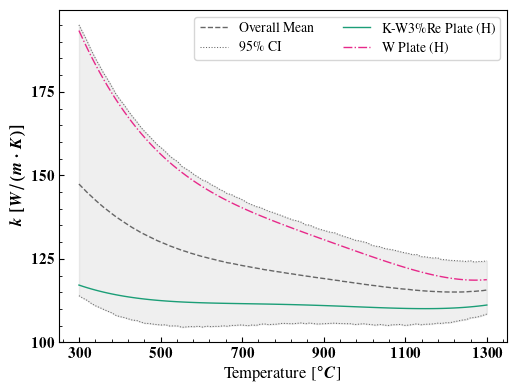

In [10]:
fig,ax = plt.subplots(figsize = (5,3.75))
setup_axis_default(ax)
ax.set_xlabel('Temperature [C]',fontsize = 12)
ax.set_ylabel('Conductivity [\%]',fontsize = 12)

sum_color = plt.get_cmap('Dark2')(0.9)
ax.plot(xnew,mean_uts,lw = 1.,zorder = 100,color = sum_color,ls = '--',label = 'Overall Mean')
ax.plot(xnew,low_uts,lw = 0.75,color  = sum_color,ls = ':',label = '95\% CI') 
ax.plot(xnew,high_uts,lw = 0.75,color  = sum_color,ls = ':')
ax.fill_between(xnew[:,0],low_uts,high_uts,color = sum_color,alpha = 0.1)

labels = {'K-doped W-3%Re (H) Plate':'K-W3\%Re Plate (H)',
          'Pure W (H) Plate': 'W Plate (H)'}

for alloy,color,ls in zip(labels,plt.get_cmap('Dark2')([0.1,0.4]),['-','-.']):
    ax.plot(xnew,alloy_conductivity[alloy],lw = 1.,zorder = 100,color = color,
            label = labels[alloy],ls = ls)

ax.legend(fontsize = 10,ncols = 2)  
ax.set_xlabel('Temperature [$^\circ C$]',fontsize = 12)
ax.set_xticks(np.arange(300,1400,200))
ax.set_yticks(np.arange(100,200,25))
ax.set_ylabel('$k \ [W/(m \cdot K)]$',fontsize = 12)

fig.tight_layout(pad = 0.1)

### Final Visualizations over the Data

Finally, let's visualize these four functions over the whole gathered dataset of conductivity. The "overall mean" falls close to the Hust-Lankford Model, while the fit to the pure W data is very optimistic compared to most other results. On the other end of things, the fitted lower bound is close to the model provided by ITER MPH for WL10. 

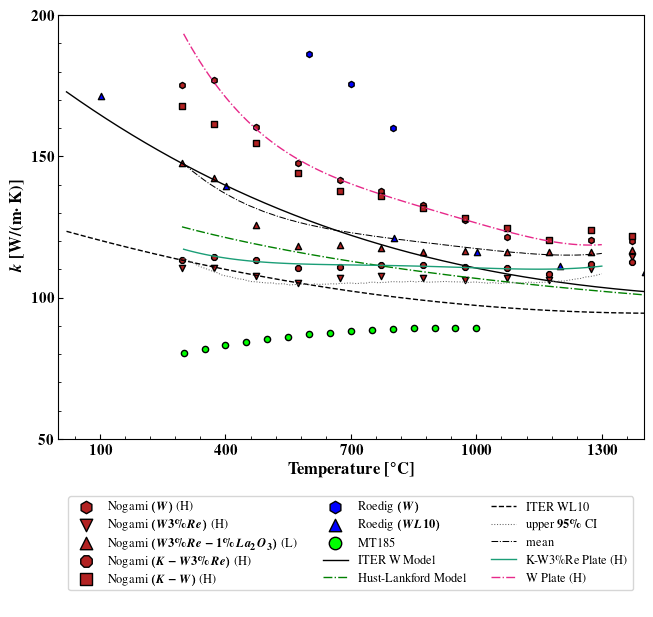

In [15]:
import pickle

with open(paths.SCRATCH.joinpath('conductivity_data_fig.pkl'),'rb') as f:
    data = pickle.load(f)
    fig,axes = data
    ax,legend_ax = axes

sum_color = plt.get_cmap('Dark2')(0.9)
ax.plot(xnew,low_uts,lw = 0.75,color  = sum_color,ls = ':',label = 'upper $95\%$ CI') 
ax.plot(xnew,mean_uts,lw = 0.75,color  = 'k',ls = '-.',label = 'mean') 

labels = {'K-doped W-3%Re (H) Plate':'K-W3\%Re Plate (H)',
          'Pure W (H) Plate': 'W Plate (H)'}

for alloy,color,ls in zip(labels,plt.get_cmap('Dark2')([0.1,0.4]),['-','-.']):
    ax.plot(xnew,alloy_conductivity[alloy],lw = 1.,zorder = 100,color = color,
            label = labels[alloy],ls = ls)

handles,_ = ax.get_legend_handles_labels()
legend_ax.legend(handles = handles,loc = 'center',ncol = 3,fontsize = 9,markerscale = 2) 
fig.tight_layout(pad = 0.1)
fig.savefig(paths.GIT_IMAGES.joinpath('conductivity_data_fit.svg'))

#### Application Practicalities

We'll use this conductivity model to inform thermal-fluid simulations. Unfortunately, the simulations need acess to the conductivity values at extremely high temperatures ($\sim 2000 ^\circ C$), substantially beyond the range of the data provided here. The Hust-Lankford model is for pure $W$ and is valid up until near the melting temperature, $\sim 3000 ^\circ C$. 

Motivated by the fact that the conductivity values appear to be converging towards a common value at higher temperatures, we can meld the fitted models with the Hust-Lankford model using a piecewise fit to the data. 

Below is an example of this "spline-ing" for two of the fitted alloys. The result looks kindof janky, but based on the lack of data we have, it provides a reasonable extrapolative thermal conductivity.

no model for this material: W-1%Re (H) Plate


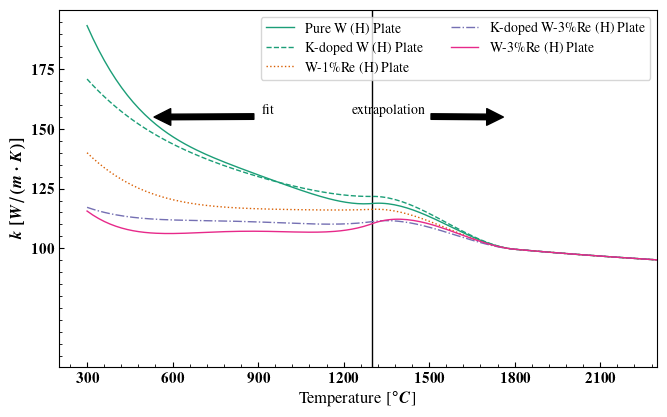

In [14]:
from common_util import StichPolynomialSplineModel
material_to_cond = {'K-doped W (H) Plate': ['K-W Plate (H)'],
                    'K-doped W-3%Re (H) Plate':['K-W3%Re Plate (H)','K-W3%Re Plate (L)'],
                    'W-3%Re (H) Plate':['W3%Re Plate (H)','W3%Re Plate (L)'],
                    'Pure W (H) Plate': ['W Plate (H)']}

columns = ['Pure W (H) Plate','K-doped W-3%Re (H) Plate']

T_eval = np.array([1300.,1800.])[:,np.newaxis]    
xplot = np.concatenate([xnew.squeeze(),
                        np.linspace(xnew.max() + 1,3500,200)])[:,np.newaxis]   
 
fig,ax = plt.subplots(figsize = (6.5,4),ncols = 1) 
setup_axis_default(ax)

padded_samples = []
for column,ls,color in zip(nogami_data.keys(),['-','--',':','-.','-'],plt.get_cmap('Dark2')(np.arange(0,1,0.1))):
    if column in remove_data:
        x,y = clean_data(*nogami_data[column], remove_data[column])
    else:
        x,y = nogami_data[column]
    
    pipe = Pipeline([('transform',data_transform),
                     ('model',LinearRegression(fit_intercept= False))])
    
    splined_model = StichPolynomialSplineModel(pipe)
    splined_model.fit(x,y,T_eval)

    try:
        for material_name in material_to_cond[column]:
            with open(paths.MODEL.joinpath(f'{material_name}_k.pkl'),'wb') as f:
                pickle.dump(splined_model,f)
    except KeyError as ke:
        print(f'no model for this material: {column}')
        
    padded_samples.append(np.repeat(splined_model.predict(xplot[xnew.shape[0]:,:]),2000,axis = -1))
    ax.plot(xplot,splined_model.predict(xplot),lw = 1.,zorder = 100,ls = ls,color = color,
            label = column.replace('%','\%'))
            

padded_samples = np.concatenate(padded_samples,axis = 1)
total_samples = np.concatenate([posterior_samples,padded_samples],axis = 0)
with open(paths.SCRATCH.joinpath('conductivity_total_samples.pkl'),'wb') as f:
    pickle.dump((xplot,total_samples),f)

#annotation and set up plot
ax.set_xlabel('Temperature [$^\circ C$]',fontsize = 12)
ax.set_xticks(np.arange(300,2500,300))
ax.set_yticks(np.arange(100,200,25))
ax.set_xlim([200,2300])
ax.set_ylabel('$k \ [W/(m \cdot K)]$',fontsize = 12)

ax.annotate('extrapolation', xy=(0.75, 0.7), xytext=(0.55, 0.71),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=10, ha='center',xycoords = 'axes fraction')

ax.annotate('fit',xy=(0.15, 0.7), xytext=(0.35, 0.71),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=10, ha='center',xycoords = 'axes fraction')

ax.axvline(1300,lw = 1.,ls = '-',color = 'k')
ax.legend(fontsize = 10,ncol = 2)
ax.set_ylim([50,200])
fig.tight_layout(pad = 0.1)



### A Digression into the details of spline

This isn't really neccessary to read, its taken care of in the class in [common_util.py](common_util.py). I just typed it out here to make sure I was doing it correctly. the conductivity $k(T)$ is:

$$
k(T) = \begin{cases} 
f(T) \qquad & 300 ^\circ C \leq T \leq 1300 ^\circ C \\ 
p(T) \qquad & 1300 ^\circ C < T \leq 1500 ^\circ C \\ 
h(T) \qquad & T > 1500 ^\circ C
\end{cases}
$$

where $f(T)$ is the fitted function for a particular alloy, $h(T)$ is the Hust-Lankford model, and $p(T) \in \mathbb{P}^r$ is a "bridging polynomial" of degree $r$ - effectively a _spline_. We'll enforce consistency of the value and derivative of the bridging polynomial with $f$ and $h$ on the respective ends of the bridging temperature interval. The minimum polynomial order that permits this is a polynomial of degree 3, that is:

$$
p(T) = c_0 + c_1 T + c_2 T^2 + c_3 T^3 \\ 
p^\prime(T) = c_1 + 2 c_2 T + 3 c_3 T^2
$$

The equality value constraints mean that at $T_1 = 1300 ^\circ C, T_2 = 1500 ^\circ C$:

$$
p(T_1) = f(T_1) = c_0 + c_1 T_1 + c_2 T_1^2 + c_3 T_1^3 \\
p(T_2) = h(T_2) = c_0 + c_1 T_2 + c_2 T_2^2 + c_3 T_2^3
$$

whilst the derivate requirements demand that: 

$$
p^\prime (T_1) = f^\prime(T_1) = c_1 + 2 c_2 T_1 + 3 c_3 T_1^2 \\
p^\prime(T_2) = h^\prime(T_2) = c_1 + 2 c_2 T_2 + 3 c_3 T_2^2
$$

which yields the following linear system:

$$
\begin{bmatrix} 
1 & T_1 & T_1^2 & T_1^3 \\ 
1 & T_2 & T_2^2 & T_2^3 \\ 
0 & 1 & 2 T_1 & 3 T_1^2 \\ 
0 & 1 & 2 T_2 & 3 T_2^2
\end{bmatrix} \begin{bmatrix} c_0 \\ c_1 \\ c_2 \\ c_3 \end{bmatrix} = \begin{bmatrix} f(T_1) \\ h(T_2) \\ f^\prime(T_1) \\ h^\prime(T_2) \end{bmatrix}
$$

Which we can solve for the coefficients $\mathbf{c} \in \mathbb{R}^4$